# Track analysis for DeepRacer

This notebook has been built based on the `Training_analysis.ipynb` provided by the AWS DeepRacer Community Team. It has been refocused on analysing waypoint and other data to build useful inputs to reward functions.

## Usage

I have expanded this notebook from to present how I'm using this information. It contains descriptions that you may find not that needed after initial reading. Since this file can change in the future, I recommend that you make its copy and reorganize it to your liking. This way you will not lose your changes and you'll be able to add things as you please.

**This notebook isn't complete.** What I find interesting in the tracks may not be what you will find interesting and useful. I recommend you get familiar with the tools and try hacking around to get the insights that suit your needs.

## Contributions

As usual, your ideas are very welcome and encouraged so if you have any suggestions either bring them to [the AWS DeepRacer Community](http://join.deepracing.io) or share as code contributions.

## Training environments

Depending on whether you're running your training through the console or using the local setup, and on which setup for local training you're using, your experience will vary. As much as I would like everything to be taylored to your configuration, there may be some problems that you may face. If so, please get in touch through [the AWS DeepRacer Community](http://join.deepracing.io).

## Requirements

Before you start using the notebook, you will need to install some dependencies. If you haven't yet done so, have a look at [The README.md file](/edit/README.md#running-the-notebooks) to find what you need to install.

Apart from the install, you also have to configure your programmatic access to AWS. Have a look at the guides below, AWS resources will lead you by the hand:

AWS CLI: https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html

Boto Configuration: https://boto3.amazonaws.com/v1/documentation/api/latest/guide/configuration.html

## Credits

I suggest following [codelikeamother blog](https://codelikeamother.uk) where you can get great tips on working with AWS DeepRacer.


## Imports

Run the imports block below:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

#Shapely Library
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

import track_utils as tu
import log_analysis as la
import cw_utils as cw

# Make sure your boto version is >= '1.9.133'
cw.boto3.__version__

'1.9.245'

This block below has been prepared in case you would like to make some changes to the utility code that comes with this notebook. It will reload track_utlis.py, log_analysis.py and cw_utils.py without the need to reload the notebook. In normal usage of the notebook you will not need it.

In [2]:
# reload log_analysis and the rest of stuff here if needed
# (handy for code updates in utils, doesn't break anything if no changes)
import importlib
importlib.reload(la)
importlib.reload(cw)
importlib.reload(tu)

<module 'track_utils' from '/home/deepracer_drunkenmonkey/aws-deepracer-workshops/log-analysis/track_utils.py'>

## Load waypoints for the track you want to run analysis on

The track waypoint files usually show up as new races start. Be sure to check for them in repository updates. You only need to load them in the block below.

These files represent the coordinates of characteristic points of the track - the center line, inside border and outside border. Their main purpose is to visualise the track in images below. One thing that you may want to remember is that at the moment not all functions below work with all values of the coordinates. Especially some look awkward with bigger tracks or with negative coordinates. Usually there is an explanation on what to do to fix the view.

The naming of the tracks is not super consistent. I'm also not sure all of them are available in the console or locally. You may want to know that:
* London_Loop and Virtual_May19_Train_track - are the AWS DeepRacer Virtual League London Loop tracks
* Tokyo - is the AWS DeepRacer Virtual League Kumo Torakku track
* New_York - are the AWS DeepRacer Virtual League Empire City training and evaluation tracks
* China - are the AWS Deepracer Virtual League Shanghai Sudu training and evaluation tracks
* reinvent_base - is the re:Invent 2019 racing track

There are also other tracks that you may want to explore. Each of them has its own properties that you might find useful for your model.

Remeber that evaluation npy files are a community effort to visualise the tracks in the trainings, they aren't 100% accurate.

Tracks Available:

In [3]:
!ls tracks/

AWS_track.npy	      H_track.npy	       Oval_track.npy
Bowtie_track.npy      London_Loop_Train.npy    reinvent_base.npy
Canada_Eval.npy       Mexico_track_eval.npy    Straight_track.npy
Canada_Training.npy   Mexico_track.npy	       Tokyo_Training_track.npy
China_eval_track.npy  New_York_Eval_Track.npy  Virtual_May19_Train_track.npy
China_track.npy       New_York_Track.npy


Take the name from results above and paste below to load the key elements of the track and view the outline of it.

Loaded 71 waypoints


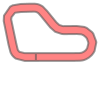

In [4]:
l_center_line, l_inner_border, l_outer_border, road_poly = tu.load_track("reinvent_base")

road_poly

## Process the waypoints to map the angles between them

We will use this data to provide input to the later sections

In [38]:
#load the track waypoints
waypoints = tu.get_track_waypoints("reinvent_base")

#split the nparray into three lists of coordinates (assume inside, mid and outside of track)
waypoints1 = waypoints[:,0:2]  # Use 0:2 as a dummy slice to maintain a 2d array
waypoints2 = waypoints[:,2:4]  # Use 2:4 as a dummy slice to maintain a 2d array
waypoints3 = waypoints[:,4:6]  # Use 4:6 as a dummy slice to maintain a 2d array
angles = np.zeros(shape=(len(waypoints),1))

#work out the angle between midpoint and the previous and next midpoint
for num, waypoint in enumerate(waypoints2):
    if num == 0:
        #do the angle using the last waypoint as your previous one (skip the actual last as its a dupe of first)
        angle = tu.get_angle(waypoints2[len(waypoints2)-2], waypoints2[num], waypoints2[num+1])
        angles[num] = abs(angle) - 180 #not interested in direction and the get_angle seems to return 180 or -180 for straight
    elif num == (len(waypoints2)-1):
        #do the angle using the first waypoint as your next one (skip actual 0 index as it duplicates the last)
        angle = tu.get_angle(waypoints2[num-1], waypoints2[num], waypoints2[1])
        angles[num] = abs(angle) - 180 #not interested in direction and the get_angle seems to return 180 or -180 for straight
    else:
        #use the index before and after to compute the angle
        angle = tu.get_angle(waypoints2[num-1], waypoints2[num], waypoints2[num+1])
        angles[num] = abs(angle) - 180 #not interested in direction and the get_angle seems to return 180 or -180 for straight
        
#now the last column is angle between waypoints
waypoints = np.hstack((waypoints, angles))
waypoints                                        

array([[ 2.90999528e+00,  6.83192475e-01,  2.90990644e+00,
         9.84078750e-01,  2.91012001e+00,  3.82306208e-01,
         0.00000000e+00],
       [ 3.31999523e+00,  6.83339053e-01,  3.31990641e+00,
         9.84200878e-01,  3.32011993e+00,  3.82477232e-01,
        -2.84217094e-14],
       [ 3.41999522e+00,  6.83374804e-01,  3.41990640e+00,
         9.84230666e-01,  3.42011992e+00,  3.82518945e-01,
        -2.84217094e-14],
       [ 3.63000234e+00,  6.83449884e-01,  3.62991234e+00,
         9.84293221e-01,  3.63012822e+00,  3.82606546e-01,
         0.00000000e+00],
       [ 4.18999512e+00,  6.83650086e-01,  4.18990633e+00,
         9.84460029e-01,  4.19011978e+00,  3.82840137e-01,
        -2.84217094e-14],
       [ 4.50000223e+00,  6.83760917e-01,  4.49991226e+00,
         9.84552371e-01,  4.50012807e+00,  3.82969451e-01,
        -1.42108547e-13],
       [ 4.54999507e+00,  6.83778790e-01,  4.54990630e+00,
         9.84567263e-01,  4.55011972e+00,  3.82990304e-01,
        -1.1368683

## Now work out suggested actions for each waypoint based on the previous and next sets of waypoints

Logic for this is that we'd want throttle low and steering angles to be more going into a hairpin.  But if coming out of a hairpin or on a straight the reqard fucntion will likely want to favour high throttle and low steering angles.

In [43]:
Action_Hints = [['Straight', 0],
                ['Entering Curve', 1],
                ['Continued Curve', 2], 
                ['Exiting Curve', 3], 
                ['Entering Hairpin', 4],
                ['Continued Hairpin', 5],
                ['Exiting Hairpin', 6]]

ActionStraight = 0
ActionEnterCurve = 1
ActionContinuedCurve = 2
ActionExitingCurve = 3
ActionEnterHairpin = 4
ActionContinuedHairpin = 5
ActionExitingHairpin = 6



#we're going to store the index of the action hint, the current angle 
# and the cumulative 3 previous, and 3 future waypoint angles 
track_Condition = np.zeros(shape=(len(waypoints),4))
#work out the future track conditions
for num, waypoint in enumerate(waypoints):
    angle0 = waypoints[num, 6]
    if num == len(waypoints)-1: #handle last index
        angle1 = waypoints[1, 6] #skipping 0 as 0 and last index are same
        angle2 = waypoints[2, 6] #skipping 0 as 0 and last index are same
    elif num == len(waypoints)-2: #handle second to last
        angle1 = waypoints[num+1, 6]
        angle2 = waypoints[1, 6] #skipping 0 as 0 and last index are same
    else: #normal index
        angle1 = waypoints[num+1, 6]
        angle2 = waypoints[num+2, 6]
    futureavg = (angle0 + angle1 + angle2) / 3
    #store current angle, and future angle
    track_Condition[num,2] = angle0
    track_Condition[num,3] = futureavg  
    #average of future might be useful too
    
#work out the recent track conditions
for num, waypoint in enumerate(waypoints):
    angle0 = waypoints[num, 6]
    if num == 0: #handle first index
        angleminus1 = waypoints[len(waypoints)-2, 6] #skipping last index as first and last are same
        angleminus2 = waypoints[len(waypoints)-3, 6] #skipping last index as first and last are same
    elif num == 1: #handle second index
        angleminus1 = waypoints[0, 6]
        angleminus2 = waypoints[len(waypoints)-2, 6] #skipping last index as first and last are same
    else: #normal index
        angleminus1 = waypoints[num-1, 6]
        angleminus2 = waypoints[num-2, 6]
    #store recent track condition
    pastavg = (angle0 + angleminus1 + angleminus2) / 3
    track_Condition[num,1] = pastavg 


track_Condition

array([[ 0.00000000e+00, -4.50963631e+00,  0.00000000e+00,
        -1.89478063e-14],
       [ 0.00000000e+00, -9.47390314e-15, -2.84217094e-14,
        -1.89478063e-14],
       [ 0.00000000e+00, -1.89478063e-14, -2.84217094e-14,
        -1.89478063e-14],
       [ 0.00000000e+00, -1.89478063e-14,  0.00000000e+00,
        -5.68434189e-14],
       [ 0.00000000e+00, -1.89478063e-14, -2.84217094e-14,
        -9.47390314e-14],
       [ 0.00000000e+00, -5.68434189e-14, -1.42108547e-13,
        -9.47390314e-14],
       [ 0.00000000e+00, -9.47390314e-14, -1.13686838e-13,
        -5.68434189e-14],
       [ 0.00000000e+00, -9.47390314e-14, -2.84217094e-14,
        -1.47104541e-01],
       [ 0.00000000e+00, -5.68434189e-14, -2.84217094e-14,
        -2.20230662e+00],
       [ 0.00000000e+00, -1.47104541e-01, -4.41313622e-01,
        -2.20230662e+00],
       [ 0.00000000e+00, -2.20230662e+00, -6.16560623e+00,
        -7.62982700e+00],
       [ 0.00000000e+00, -2.20230662e+00, -3.12638804e-13,
      

In [44]:
#define some values for absolute angles
CurveAngle = 20
HairpinAngle = 40
Straight = 10

IndexCondition = 0
IndexPast = 1
IndexCurrent = 2
IndexFuture = 3


#loop through the new array and allocate category    
for num, angles in enumerate(track_Condition):
    #average of past might be useful too
    #also might be use similarity between past, current and future?
    
    #base most of hints on future track space
    if abs(angles[IndexFuture])<Straight: 
        if abs(angles[IndexPast])<Straight:
            track_Condition[num,0] = ActionStraight
        if (abs(angles[IndexPast])>Straight) & (abs(angles[IndexPast])<CurveAngle):
            track_Condition[num,0] = ActionExitingCurve
        if abs(angles[IndexPast])>CurveAngle:
            track_Condition[num,0] = ActionExitingHairpin
    elif (abs(angles[IndexFuture])>Straight) & (abs(angles[IndexFuture])<CurveAngle):
        if abs(angles[IndexPast])<Straight:
            track_Condition[num,0] = ActionEnterCurve
        if (abs(angles[IndexPast])>Straight & (abs(angles[IndexPast])<CurveAngle)):
            track_Condition[num,0] = ActionContinuedCurve
        if abs(angles[IndexPast])>CurveAngle:
            track_Condition[num,0] = ActionEnterCurve
    elif abs(angles[IndexFuture])>CurveAngle:
        if abs(angles[IndexPast])<Straight:
            track_Condition[num,0] = ActionEnterHairpin
        if (abs(angles[IndexPast]>Straight) & (abs(angles[IndexPast])<CurveAngle)):
            track_Condition[num,0] = ActionEnterHairpin
        if abs(angles[IndexPast])>CurveAngle:
            track_Condition[num,0] = ActionContinuedHairpin
        
track_Condition    

array([[ 0.00000000e+00, -4.50963631e+00,  0.00000000e+00,
        -1.89478063e-14],
       [ 0.00000000e+00, -9.47390314e-15, -2.84217094e-14,
        -1.89478063e-14],
       [ 0.00000000e+00, -1.89478063e-14, -2.84217094e-14,
        -1.89478063e-14],
       [ 0.00000000e+00, -1.89478063e-14,  0.00000000e+00,
        -5.68434189e-14],
       [ 0.00000000e+00, -1.89478063e-14, -2.84217094e-14,
        -9.47390314e-14],
       [ 0.00000000e+00, -5.68434189e-14, -1.42108547e-13,
        -9.47390314e-14],
       [ 0.00000000e+00, -9.47390314e-14, -1.13686838e-13,
        -5.68434189e-14],
       [ 0.00000000e+00, -9.47390314e-14, -2.84217094e-14,
        -1.47104541e-01],
       [ 0.00000000e+00, -5.68434189e-14, -2.84217094e-14,
        -2.20230662e+00],
       [ 0.00000000e+00, -1.47104541e-01, -4.41313622e-01,
        -2.20230662e+00],
       [ 0.00000000e+00, -2.20230662e+00, -6.16560623e+00,
        -7.62982700e+00],
       [ 0.00000000e+00, -2.20230662e+00, -3.12638804e-13,
      